In [1]:
import pandas as pd
import numpy as np
import string
import json
# from IPython.display import display
import re
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from  datetime import datetime
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import scipy.misc
from pathlib import Path
from urlpath import URL
import os
from copy import deepcopy
import mxnet as mx
import cv2
import cv2 as cv
import numpy as np
from gluoncv.data import ImageNet1kAttr
from gluoncv.data.transforms.presets.imagenet import transform_eval
from mxnet import nd
# import face_recognition
from facial_emotion_recognition import EmotionRecognition
import torch
from facenet_pytorch import MTCNN
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from gluoncv import model_zoo, data, utils

from matplotlib.pyplot import imshow,subplots
# %matplotlib inline


pd.options.display.max_columns = None
# Use 'display(df)' instead of 'df' to display all columns.

In [2]:
%pip install face_recognition

Note: you may need to restart the kernel to use updated packages.


In [19]:
PATH = "./../../../data/thumbnailsHQ/Etap5/"


In [2]:
def readJSONList(path):
    with open(path, 'r') as file:
        loaded_list = json.loads(file.read())
    return loaded_list

def writeJSONList(path, list_to_save):
    with open(path, 'w') as file:
        file.write(json.dumps(list_to_save))

def downloadThumbnails(df, quality='hq'):
    list_of_ids_without_thumbnail = []
    ids = df["video_id"].values
    urls = df["thumbnail_link"].values
    
    region = df['region'][0]
    Path("./../../data/thumbnailsHQ/Etap5/" + region).mkdir(parents=True, exist_ok=True)
    savepath = Path("./../../data/thumbnailsHQ/Etap5/" + region)
    filename = quality + 'default.jpg'
    
    for id, url in zip(ids, urls): 
        temp_url = URL(url)
        temp_url = temp_url.parent / filename
        
        try:
            img = io.imread(str(temp_url))
        except Exception:
            list_of_ids_without_thumbnail.append(id)
            print(f"{id} no thumbnail")
            continue
        io.imsave(savepath / (id + ".png") , img)
    
    writeJSONList(savepath / "ids_without_thumbnail.txt", list_of_ids_without_thumbnail)
        
    return list_of_ids_without_thumbnail

In [3]:
# downloadThumbnails(dfUS)



def load_files(df,list_of_files):
    images = []
    images_raw = []
    ids = []
    path="./../../../data/thumbnailsHQ/Etap5/"
    for index, row in df.iterrows():
        if (""+row['video_id']+".png") in list_of_files:
            img_path = path+row['video_id']+".png"
            img = image.load_img(img_path, target_size=(299, 299))
            x = image.img_to_array(img)
            images.append(x)
            ids.append(row['video_id'])
            images_raw.append(img)          
        else:
            pass    
    images_np = np.array(deepcopy(images))
    print(images_np.shape)
    return images_np, ids,images_raw


def load_filescv(df,list_of_files):
    images = []
    images_raw = []
    ids = []
    path="./../../../data/thumbnailsHQ/Etap5/"
    for index, row in df.iterrows():
        if (""+row['video_id']+".png") in list_of_files:
            img_path = path+row['video_id']+".png"
            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            x = image.img_to_array(img)
            images.append(x)
            ids.append(row['video_id'])
            images_raw.append(img)       
        else:
            pass
    
    images_np = np.array(deepcopy(images))
    print(images_np.shape)
    return images_np, ids,images_raw


def load_filesfr(df,list_of_files):
    images = []
    images_raw = []
    ids = []
    path="./../../../data/thumbnailsHQ/Etap5/"
    for index, row in df.iterrows():
        if (""+row['video_id']+".png") in list_of_files:
            img_path = path+row['video_id']+".png"
            img = face_recognition.load_image_file(img_path)
            x = image.img_to_array(img)
            images.append(x)
            ids.append(row['video_id'])
            images_raw.append(img)       
        else:
            pass
    
    images_np = np.array(deepcopy(images))
    print(images_np.shape)
    return images_np, ids,images_raw

def get_predictionsYolo(df,list_of_files):
    images,ids,images_raw = load_files(df,list_of_files)
    net = model_zoo.get_model('yolo3_darknet53_coco',pretrained=True)
    narray = mx.ndarray.array(images)
    labels_all = []
    for img in narray:
        x, img = data.transforms.presets.yolo.transform_test(img, short=512)
        class_IDs, scores, bounding_boxs = net(x)
#         ax = utils.viz.plot_bbox(img, bounding_boxs[0], scores[0],
#                                  class_IDs[0], class_names=net.classes)
#         plt.show()
        labels_img = []
        labels= np.array(net.classes)
        nids = class_IDs.asnumpy()
        nscores = scores.asnumpy()
        length = len(class_IDs[0])
#         print(length)
        for l in range(length):
            if nids.item(l) != -1:
                labels_img.append([labels[int(nids.item(l))],nscores.item(l)])
            else:
                break

        labels_all.append(labels_img)
        

    return list(zip(labels_all,ids))

def get_predictionsRESNET(df,list_of_files):
    images,ids,images_raw = load_files(df,list_of_files)
    net = model_zoo.get_model('resnet152_v1b',pretrained=True)
    narray = mx.ndarray.array(images)
    labels_all = []
    classes = net.classes
    for img in narray:
        x = transform_eval(img)
        pred = net(x)
#         plt.imshow(images_raw[0])
#         plt.show()
        labels_img = []
        topK = 5
        ind = nd.topk(pred, k=topK)[0].astype('int')
        for i in range(topK):
            labels_img.append([classes[ind[i].asscalar()], nd.softmax(pred)[0][ind[i]].asscalar()])
        labels_all.append(labels_img)
    return list(zip(labels_all,ids))
    
def get_predictionsImagenet(df,list_of_files):
    images,ids,images_raw = load_files(df,list_of_files) 
    model = Xception(weights='imagenet')
    preds = model.predict(images)
    return decode_predictions(preds, top=3)

# def faceRecognition(df, list_of_files):    
#     images,ids,images_raw = load_filesfr(df,list_of_files)
#     for img in images_raw: 
# #         print(img)
#         face_locations = face_recognition.face_locations(img)
#         print(face_locations)
#         print("NEXT")
#     return 0

def emotionRecognition(df, list_of_files):
    er = EmotionRecognition(device='gpu', gpu_id=0)
    
    mtcnn =  MTCNN(keep_all=True, device=torch.device(f'cuda:0'))
    emotions_all = []
    
    images,ids,images_raw = load_filescv(df,list_of_files)
    print(len(images_raw))
    for frame in images_raw:
        emotions_image = []
        f_h, f_w, c = frame.shape
        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        boxes, _ = mtcnn.detect(frame)
        if boxes is not None:
            for i in range(len(boxes)):
                x1, y1, x2, y2 = int(round(boxes[i][0])), int(round(boxes[i][1])), int(round(boxes[i][2])), int(
                    round(boxes[i][3]))
                emotion = er._predict(gray[y1:y2, x1:x2])
                emotions_image.append(emotion)
#                 frame = cv.rectangle(frame, (x1, y1), (x2, y2), color=[0, 255, 0], thickness=1)
#                 frame = cv.rectangle(frame, (x1, y1 - int(f_h*0.03125)), (x1 + int(f_w*0.125), y1), color=[0, 255, 0], thickness=-1)
#                 frame = cv.putText(frame, text=emotion, org=(x1 + 5, y1 - 3), fontFace=cv.FONT_HERSHEY_PLAIN,
#                                    color=[0, 0, 0], fontScale=1, thickness=1)

#             plt.imshow(frame)
#             plt.show()
#         else:
#             plt.imshow(frame)
#             plt.show()
        emotions_all.append(emotions_image)
    return list(zip(emotions_all,ids))
#         emotion = er._predict(img)
#         plt.imshow(frame)
#         plt.show()
#         print(face_locations)
#         print("NEXT")

# images_np,ids,images_raw = load_files()
# predictions = get_predictions(images_np)
# preds = faceRecognition(df,list_of_files)
# emotions_all = emotionRecognition(df,list_of_files)
# yolo_pred = get_predictionsYolo(df,list_of_files)
# print(preds)

# Przyklad wykrywania twarzy(MTCNN) i emocji  (Rayyan-Akhtar Facial_Emotion_Recognition) [github](https://github.com/Rayyan-Akhtar/Facial_Emotion_Recognition/tree/1ed5638bde6780cb85adeab770f7589d35c1057a)

In [12]:
dfGB = pd.read_csv("./../../../our_data/Etap5/Etap1/checkpoint1.csv",skiprows=range(1,503), nrows=2)
# dfUS = pd.read_csv("./US_new_columns.csv")
list_of_filesGB = []
path="./../../../data/thumbnailsHQ/Etap5/"
for root, dirs, files in os.walk(path):
    for file in files:
        list_of_filesGB.append(os.path.join(file))
list_of_filesUS = []
# print(list_of_filesGB)
emotions_all = emotionRecognition(dfGB,list_of_filesGB)  


[*] Accuracy: 0.9565809379727686
(2, 360, 480, 3)
2


# Przyklad wykrywania obiektów za pomocą yolo

In [13]:
dfGB = pd.read_csv("./../../../our_data/Etap5/Etap1/checkpoint1.csv",skiprows=range(1,534), nrows=5)
# dfUS = pd.read_csv("./US_new_columns.csv")
list_of_filesGB = []
path="./../../../data/thumbnailsHQ/Etap5/"
for root, dirs, files in os.walk(path):
    for file in files:
        list_of_filesGB.append(os.path.join(file))
list_of_filesUS = []
        
emotions_all = get_predictionsYolo(dfGB,list_of_filesGB)  


(5, 299, 299, 3)


# Przyklad klasyfikacji obrazów za pomoca resnet152_v1b

In [14]:
dfGB = pd.read_csv("./../../../our_data/Etap5/Etap1/checkpoint1.csv",skiprows=range(1,123), nrows=1)
# dfUS = pd.read_csv("./US_new_columns.csv")
list_of_filesGB = []
path="./../../../data/thumbnailsHQ/Etap5/"
for root, dirs, files in os.walk(path):
    for file in files:
        list_of_filesGB.append(os.path.join(file))
list_of_filesUS = []
        
get_predictionsRESNET(dfGB,list_of_filesGB)  



(1, 299, 299, 3)


[([['stage', 0.23737864],
   ['spotlight', 0.19988503],
   ['television', 0.058823206],
   ['projector', 0.056053773],
   ['monitor', 0.03327875]],
  'RREIsMlGlos')]

# Generowanie danych

In [4]:
# dfGB = pd.read_csv("./../../our_data/Etap1/GB.csv")
dfUS = pd.read_csv(f"./../../../our_data/Etap5/Etap1/checkpoint1.csv")

print(dfUS.shape)
# list_of_filesGB = []
# path="./../../data/thumbnailsHQ/GB/"
# for root, dirs, files in os.walk(path):
#     for file in files:
#         list_of_filesGB.append(os.path.join(file))
        
list_of_filesUS = []
path="./../../../data/thumbnailsHQ/Etap5/"
for root, dirs, files in os.walk(path):
    for file in files:
        list_of_filesUS.append(os.path.join(file))

# for i in range(7):
#     dfGB = pd.DataFrame()
#     if i > 0:
#         dfGB = pd.read_csv("./../../our_data/Etap1/GB.csv",skiprows=range(1,i*500), nrows=500)
#     else:
#         dfGB = pd.read_csv("./../../our_data/Etap1/GB.csv", skiprows=i*500, nrows=500)
    
#     print(dfGB.shape)
#     print(dfGB.columns)

#     print("I:"+str(i)+ " size: "+str(len(dfGB)))
#     print("EMOTIONS")
#     predsEmotionsGB = emotionRecognition(dfGB,list_of_filesGB)
#     df_predsEmotionsGB = pd.DataFrame(predsEmotionsGB)
#     df_predsEmotionsGB.to_csv("./../../our_data/Etap2/adam/dfGB_predsEmotions{0}.csv".format(i))
#     print("RESNET")

#     predsYOLOGB = get_predictionsYolo(dfGB,list_of_filesGB)
#     df_predsYOLOGB = pd.DataFrame(predsYOLOGB)
#     df_predsYOLOGB.to_csv("./../../our_data/Etap2/adam/dfGB_predsYOLO{0}.csv".format(i))
#     print("YOLO")
#     predsResNetGB = get_predictionsRESNET(dfGB,list_of_filesGB)
#     df_predsResNetGB = pd.DataFrame(predsResNetGB)
#     df_predsResNetGB.to_csv("./../../our_data/Etap2/adam/dfGB_predsResNet{0}.csv".format(i))



for i in range(15,17):
    dfUS = pd.DataFrame()
    if i > 0:
        dfUS = pd.read_csv("./../../../our_data/Etap5/Etap1/checkpoint1.csv",skiprows=range(1,i*500), nrows=500)
    else:
        dfUS = pd.read_csv("./../../../our_data/Etap5/Etap1/checkpoint1.csv",skiprows=i*500, nrows=500)
#     print(dfUS.shape)
    print("I:"+str(i)+ " size: "+str(len(dfUS)))
    print("EMOTIONS")
    predsEmotionsUS = emotionRecognition(dfUS,list_of_filesUS)
    df_predsEmotionsUS = pd.DataFrame(predsEmotionsUS)
    df_predsEmotionsUS.to_csv("./../../../our_data/Etap5/Etap2/adam/dfUS_predsEmotions{0}.csv".format(i))
    print("RESNET")
    predsResNetUS = get_predictionsRESNET(dfUS,list_of_filesUS)
    df_predsResNetUS = pd.DataFrame(predsResNetUS)
    df_predsResNetUS.to_csv("./../../../our_data/Etap5/Etap2/adam/dfUS_predsResNet{0}.csv".format(i))
    print("YOLO")
    predsYOLOUS = get_predictionsYolo(dfUS,list_of_filesUS)
    df_predsYOLOUS = pd.DataFrame(predsYOLOUS)
    df_predsYOLOUS.to_csv("./../../../our_data/Etap5/Etap2/adam/dfUS_predsYOLO{0}.csv".format(i))

/home/adam/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(8474, 69)
I:15 size: 500
EMOTIONS
[*] Accuracy: 0.9565809379727686
(500, 360, 480, 3)
500
RESNET
(500, 299, 299, 3)
YOLO
(500, 299, 299, 3)
I:16 size: 475
EMOTIONS
[*] Accuracy: 0.9565809379727686
(475, 360, 480, 3)
475
RESNET
(475, 299, 299, 3)
YOLO
(475, 299, 299, 3)


# Scalanie danych

In [6]:
dfGB_all = pd.read_csv("./../../../our_data/Etap5/Etap1/checkpoint1.csv")

# USA
leUS = 13
emotionUS = "./../../../our_data/Etap5/Etap2/adam/dfUS_predsEmotions{0}.csv"
resUS = "./../../../our_data/Etap5/Etap2/adam/dfUS_predsResNet{0}.csv"
yoloUS = "./../../../our_data/Etap5/Etap2/adam/dfUS_predsYOLO{0}.csv"

dfemotionUS = pd.DataFrame()
dfresUS = pd.DataFrame()
dfyoloUS = pd.DataFrame()
temp_emotions = []
temp_res = []
temp_yolo = []
for i in range(leUS):
    temp_emotions.append(pd.read_csv(emotionUS.format(i)))
    temp_res.append(pd.read_csv(resUS.format(i)))
    temp_yolo.append(pd.read_csv(yoloUS.format(i)))

# print(len(temp_emotions))
temp_emotionsDf = pd.concat(temp_emotions, sort=False)
temp_emotionsDf.columns = ['0','emotions','id']
temp_emotionsDf = temp_emotionsDf.drop('0', axis = 1)

temp_resDF = pd.concat(temp_res, sort=False)
temp_resDF.columns = ['0','categories','id']
temp_resDF = temp_resDF.drop('0', axis = 1)

temp_yoloDF = pd.concat(temp_yolo, sort=False)
temp_yoloDF.columns = ['0','objects','id']
temp_yoloDF = temp_yoloDF.drop('0', axis = 1)
# dfGBnew  = pd.

dfUS = temp_emotionsDf
dfUS = temp_emotionsDf.merge(temp_resDF, left_on='id', right_on='id')
dfUS = dfUS.merge(temp_yoloDF, left_on='id', right_on='id')




# Generowanie kolumn dla US

In [7]:
dfUS['Sad'] = [x.count("Sad") for x in dfUS['emotions']]
dfUS['Fear'] = [x.count("Fear") for x in dfUS['emotions']]
dfUS['Angry'] = [x.count("Angry") for x in dfUS['emotions']]
dfUS['Happy'] = [x.count("Happy") for x in dfUS['emotions']]
dfUS['Neutral'] = [x.count("Neutral") for x in dfUS['emotions']]
dfUS['Surprise'] = [x.count("Surprise") for x in dfUS['emotions']]


dfUS['categories_list'] = [[y.replace("'", '') for y in re.findall("'[a-z ]+'", x)] for x in dfUS['categories']]
dfUS['object_list'] = [[y.replace("'", '') for y in re.findall("'[a-z ]+'", x)] for x in dfUS['objects']]
dfUS['people'] = [x.count('person') for x in dfUS['object_list']]
# print(dfUS.columns)

for index,row in dfUS.iterrows():
    dfUS.loc[index,'faces'] = row['Sad']+row['Fear']+row['Angry']+row['Happy']+row['Neutral']+row['Surprise']
# dfUS

# Podsumowanie wykrywanych ludzi

'USA max:93'

'USA mean:4.385029203811866'

ID filmu US z największą liczbą ludzi2588    oR-eqDs3orM
3551    PjGD3ayQyY0
Name: id, dtype: object


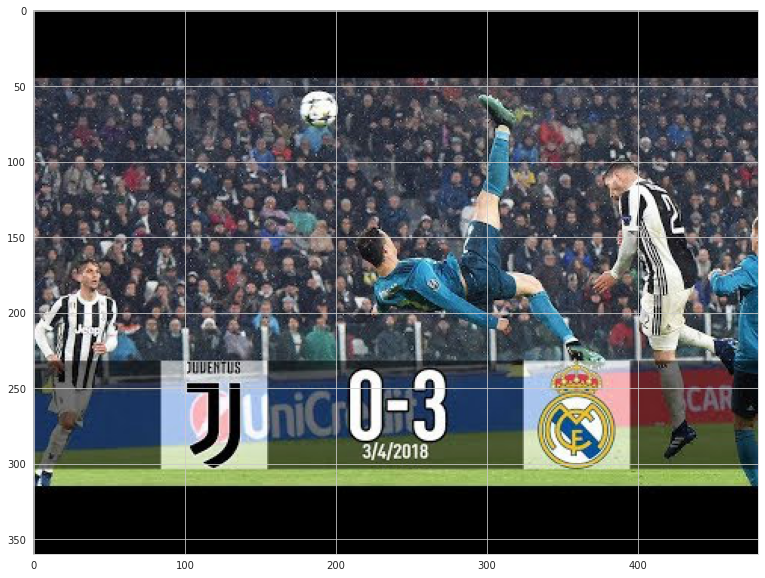

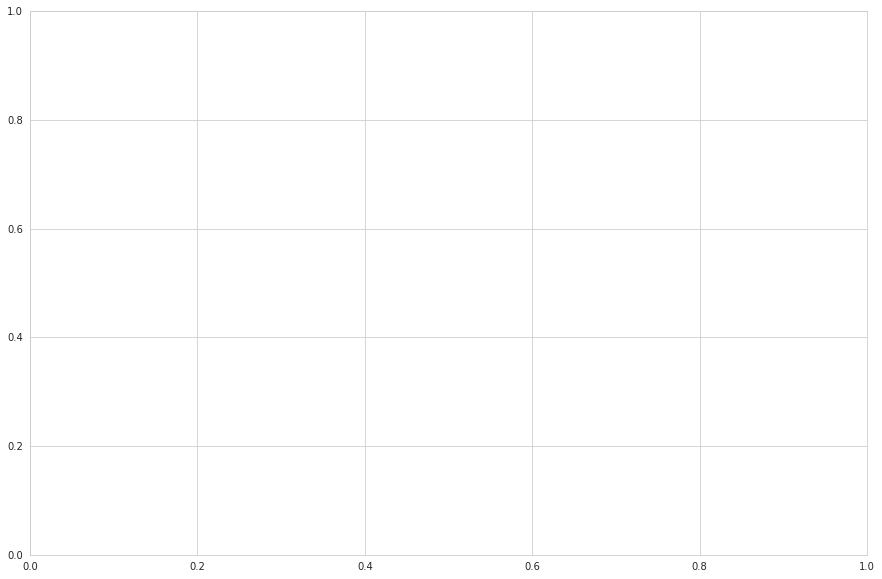

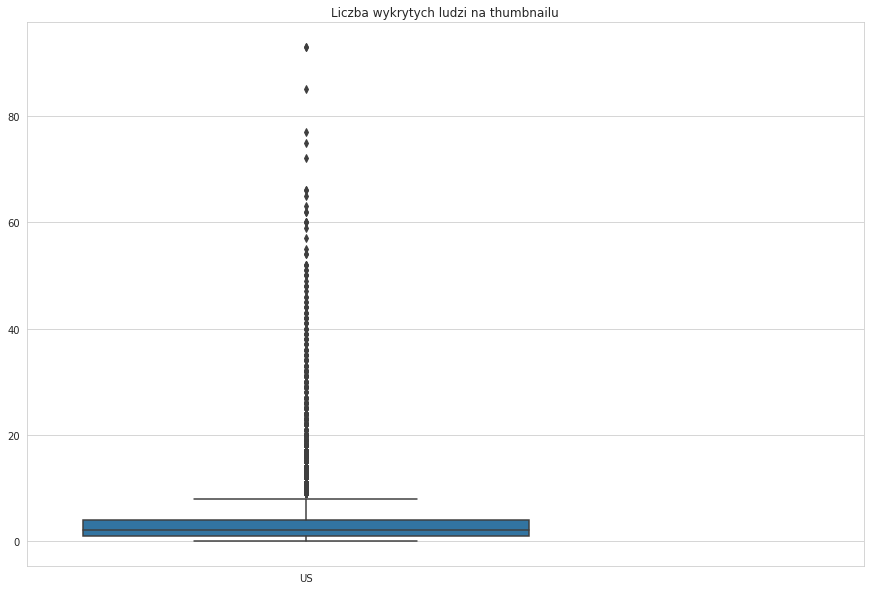

In [21]:
sns.set_style("whitegrid")
display("USA max:" + str(max(dfUS.people)) ,"USA mean:" + str(np.mean([dfUS.people])))


fig, ax = subplots(figsize=(15, 10))

print("ID filmu US z największą liczbą ludzi"+str(dfUS[dfUS.people == dfUS.people.max()]['id']))
img_path = PATH+"/oR-eqDs3orM"+".png"

img = image.load_img(img_path)
plt.imshow(img)
plt.show()
fig, ax = subplots(figsize=(15, 10))
plt.show()
# display()

fig, ax = subplots(figsize=(15, 10))
data = [dfUS.people]
ax = sns.boxplot( data=data)
ax.set_xticks([0,1])
ax.set_xticklabels(['US'])
ax.set_title("Liczba wykrytych ludzi na thumbnailu")
plt.show()

# Podsumowanie wykrytych twarzy

'USA max:28.0'

'USA mean:1.4973870273593606'

ID filmu US z największą liczbą twarzy5478    Kp3jHId3dlQ
Name: id, dtype: object


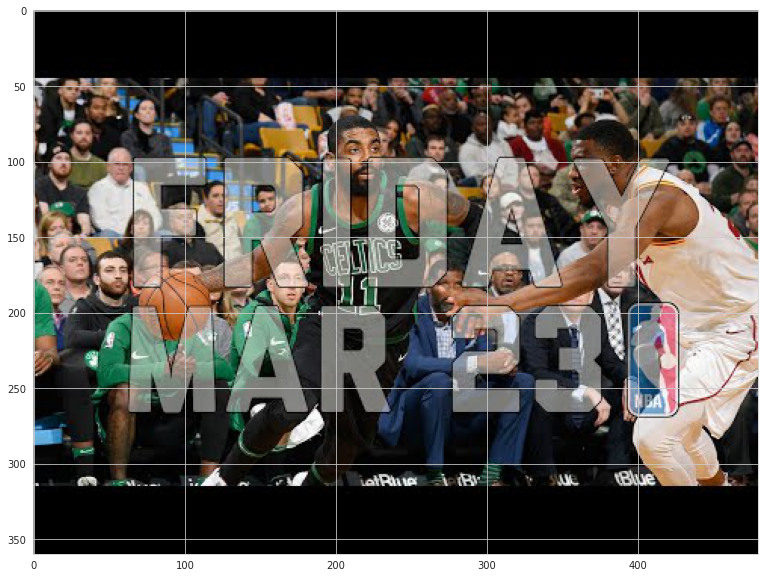

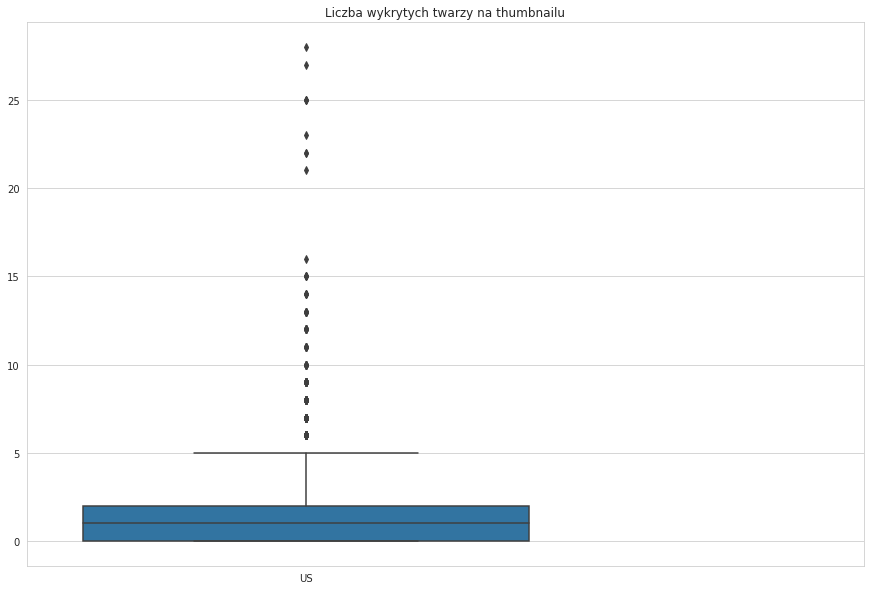

In [24]:
sns.set_style("whitegrid")
display("USA max:" + str(max(dfUS.faces)) ,"USA mean:" + str(np.mean([dfUS.faces])))


fig, ax = subplots(figsize=(15, 10))

print("ID filmu US z największą liczbą twarzy"+str(dfUS[dfUS.faces == dfUS.faces.max()]['id']))
img_path = PATH+"/Kp3jHId3dlQ"+".png"

img = image.load_img(img_path)
plt.imshow(img)
plt.show()
fig, ax = subplots(figsize=(15, 10))
# display()

data = [dfUS.faces]
ax = sns.boxplot( data=data)
ax.set_xticks([0,1])
ax.set_xticklabels(['US'])
ax.set_title("Liczba wykrytych twarzy na thumbnailu")
# ax.set(yscale="log")
plt.show()

# Podsumowanie emocji dla US

,Sad,Fear,Angry,Happy,Neutral,Surprise
count,6506.000000,6506.000000,6506.000000,6506.000000,6506.000000,6506.000000
mean,0.341223,0.096680,0.267445,0.465263,0.312481,0.014294
std,0.765160,0.334119,0.672353,0.847536,0.646843,0.122534
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,17.000000,5.000000,13.000000,13.000000,11.000000,2.000000


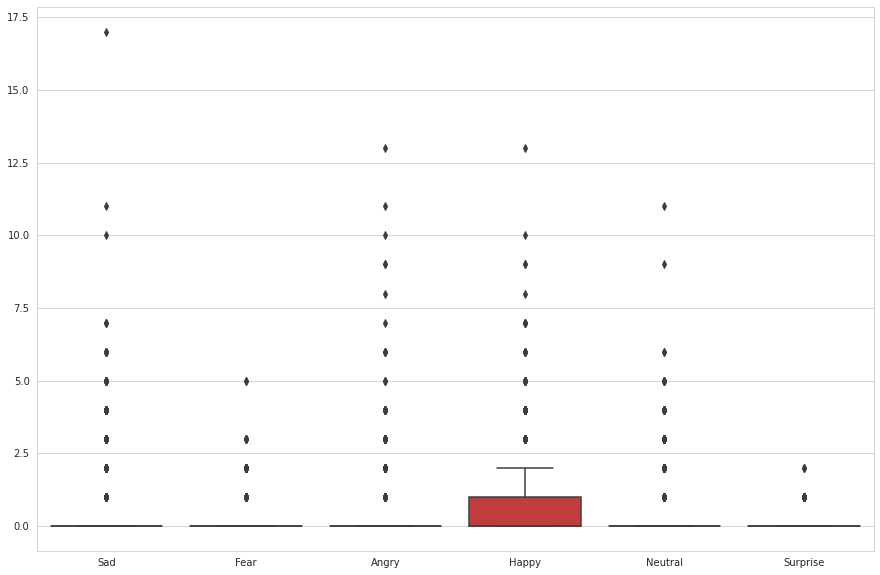

In [25]:
sns.set_style("whitegrid")
fig, ax = subplots(figsize=(15, 10))

display(dfUS.describe()[['Sad', 'Fear', 'Angry', 'Happy', 'Neutral','Surprise']])
data = dfUS[['Sad', 'Fear', 'Angry', 'Happy', 'Neutral','Surprise']]
ax = sns.boxplot( data=data)
# ax.set(yscale="log")
plt.show()


# Podsumowanie wykrytych obiektów (YOLO) dla US

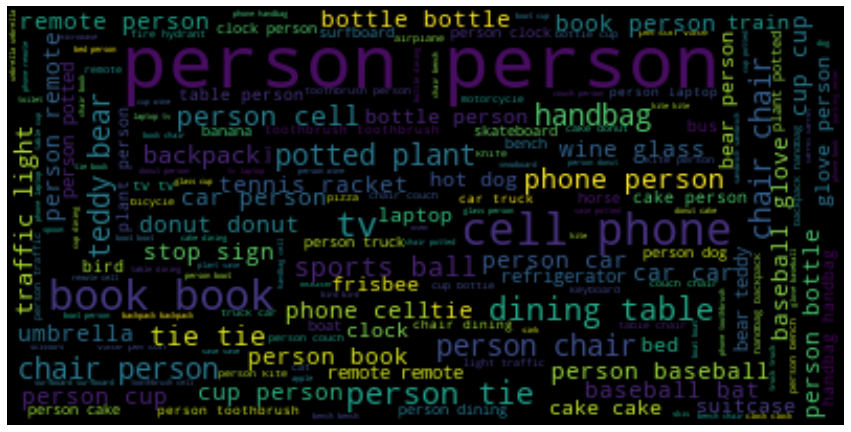

In [26]:
USwords = ""
for cat in dfUS.object_list:
    for c in cat:      
        if c != '':
            USwords = USwords+", ,"+ c
            
    
text = USwords

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)
fig, ax = subplots(figsize=(15, 10))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Podsumowanie wykrytych kategorii (resnet) dla US

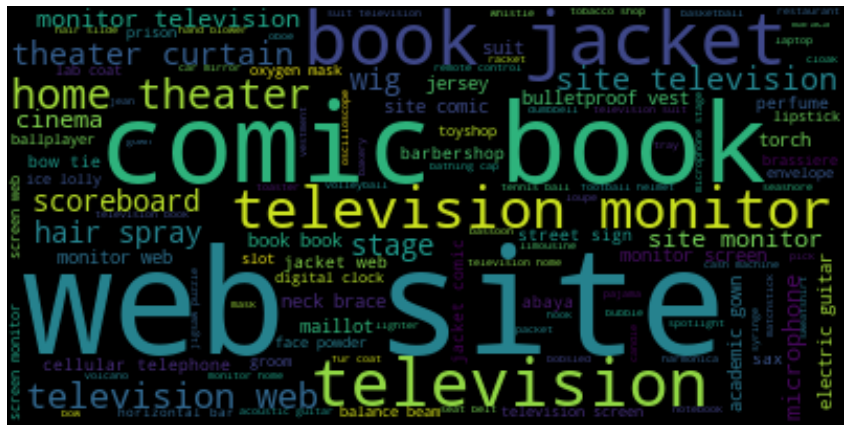

In [27]:
USwords = ""
for cat in dfUS.categories_list:
    for c in cat:      
        if c != '':
            USwords = USwords+", "+ c
            
    
text = USwords

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)
fig, ax = subplots(figsize=(15, 10))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [29]:
dfUS.to_csv("./../../../our_data/Etap5/Etap2/adam/df_finall.csv", index=False)